<a href="https://colab.research.google.com/github/jm12312/PRODIGY_ML_04/blob/main/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/gti-upm/leapgestrecog'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog


100%|██████████| 2.13G/2.13G [00:19<00:00, 120MB/s]


In [27]:
import os

In [28]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [29]:
lookup = {'10_down': 0,
 '02_l': 1,
 '04_fist_moved': 2,
 '07_ok': 3,
 '01_palm': 4,
 '03_fist': 5,
 '06_index': 6,
 '05_thumb': 7,
 '09_c': 8,
 '08_palm_moved': 9}

In [30]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Transformation for preprocessing images
transform = transforms.Compose([
    transforms.Resize((128, 128)),                # Resize image to (120, 320)
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize image data
])

x_data = []
y_data = []
datacount = 0

for i in range(10):  # Loop over the ten top-level folders
    gesture_folder = f'leapgestrecog/leapGestRecog/0{i}'

    for j in os.listdir(gesture_folder):
        if not j.startswith('.'):  # Skip hidden files/folders
            count = 0
            for k in os.listdir(os.path.join(gesture_folder, j)):
                if not k.startswith('.'):  # Skip hidden files
                    img_path = os.path.join(gesture_folder, j, k)
                    img = Image.open(img_path)  # Open image
                    img = transform(img)  # Apply transformations

                    # Append transformed image to x_data
                    x_data.append(img)

                    # Create labels for this gesture
                    label = lookup[j]
                    y_data.append(label)
                    count += 1

            datacount += count

# Convert lists to numpy arrays or tensors
x_data = torch.stack(x_data)  # Convert list of tensors into a tensor
y_data = torch.tensor(y_data)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create dataset instance
dataset = CustomDataset(x_data, y_data)

# Split into training and validation sets
train_ds, val_ds = random_split(dataset, [15000, 5000])

# Create DataLoader instances
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

# Check dataset length
print(len(dataset))

20000


In [31]:
for img, label in train_dl:
    print(img.shape)
    print(label.shape)
    break

torch.Size([32, 1, 128, 128])
torch.Size([32])


In [32]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

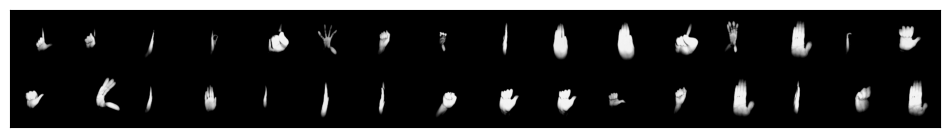

In [33]:
show_batch(train_dl)

In [34]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [36]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch: {epoch}, Train Loss: {result["train_loss"]} ,Val Loss: {result["val_loss"]}, Val Acc: {result["val_acc"]}')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CNN(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.conv1 = conv_block(1, 64, pool=True)  # 64, 64, 64
    self.conv2 = conv_block(64, 128, pool=True) # 128, 32, 32
    self.conv3 = conv_block(128, 256, pool=True) # 256, 16, 16
    self.conv4 = conv_block(256, 256, pool=True) # 256, 8, 8
    self.conv5 = conv_block(256, 256, pool=True) # 256, 4, 4
    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    return self.classifier(out)

In [39]:
model = to_device(CNN(), device)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(model, opt, train_dl, loss_fn, epochs, val_loader):
  torch.cuda.empty_cache()
  history = []
  train_loss = []
  model.train()
  for epoch in range(epochs):
    for img, label in train_dl:
      loss = model.training_step((img, label))
      train_loss.append(loss)
      loss.backward()
      opt.step()
      opt.zero_grad()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_loss).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [41]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.303380012512207, 'val_acc': 0.10131369531154633}]

In [42]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=1e-2), train_dl, F.cross_entropy, 5, val_dl)

Epoch: 0, Train Loss: 0.40522119402885437 ,Val Loss: 0.013521159999072552, Val Acc: 0.9972133636474609
Epoch: 1, Train Loss: 0.47440382838249207 ,Val Loss: 0.01596060022711754, Val Acc: 0.9962181448936462
Epoch: 2, Train Loss: 0.32225489616394043 ,Val Loss: 0.005865938030183315, Val Acc: 0.9988057613372803
Epoch: 3, Train Loss: 0.24835364520549774 ,Val Loss: 0.007043629884719849, Val Acc: 0.9984076619148254
Epoch: 4, Train Loss: 0.2027696669101715 ,Val Loss: 0.0038758667651563883, Val Acc: 0.9988057613372803


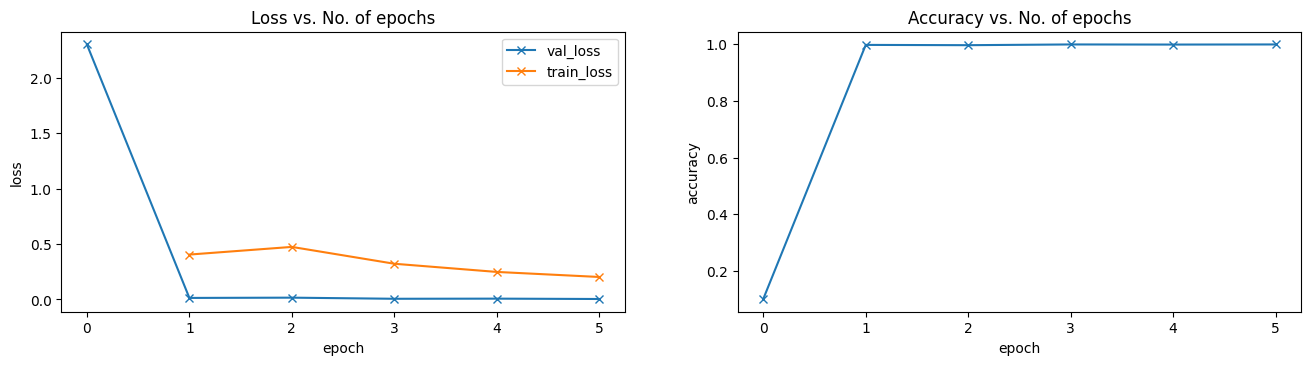

In [49]:
def plot_metrics(history):
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 2, 1)
    val_loss = [x['val_loss'] for x in history]
    train_loss = [x.get('train_loss', None) for x in history]

    plt.plot(val_loss, '-x')
    plt.plot(train_loss, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend(['val_loss', 'train_loss'])


    plt.subplot(2, 2, 2)
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_metrics(history)

In [44]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    op = model(xb)
    _, pred = torch.max(op, dim=1)
    return pred[0].item()
y_true = []
y_pred = []
for img, label in val_dl:
  for i in range(len(img)):
    y_true.append(label[i].item())
    y_pred.append(predict_image(img[i], model))

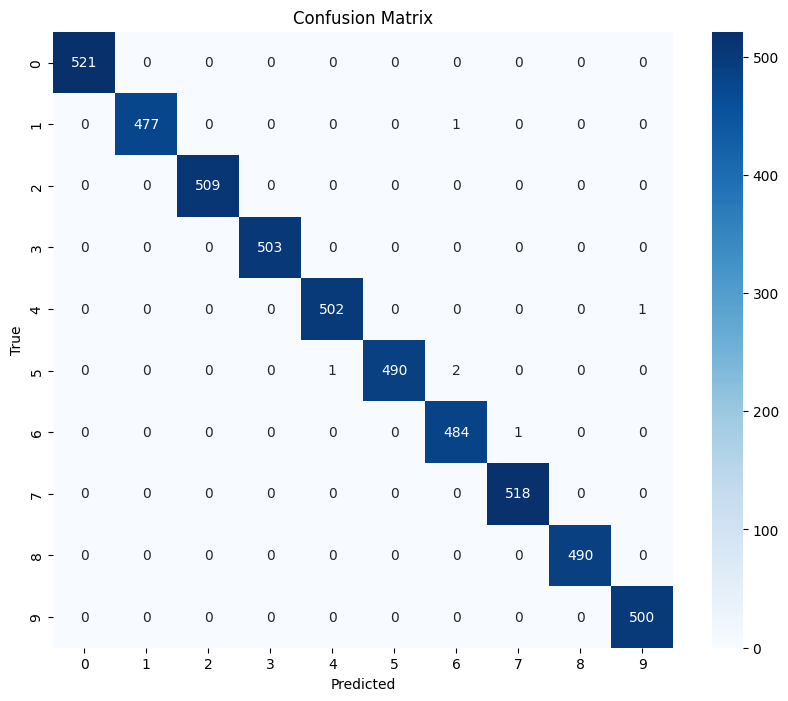

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()